# FRAMEWORK to SPOT-CHECK Machine Learning Algorithms

References: ["How to Develop a Framework to Spot-Check Machine Learning Algorithms in Python"](https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/)

Spot-checking algorithms is a technique in applied machine learning designed to quickly and objectively provide a first set of results on a new predictive modeling problem.

## for REGRESSION

### Framework:
- Load Dataset
- Define Models
    - Linear Models.
    - Nonlinear Models.
    - Ensemble Models.
- Evaluate Models
- Summarize Results

### Framework Extensions:
- Course Grid Search for Gradient Boosting: Gradient Boosting with Grid Search hiper-parameters optimization.
- Repeated Evaluations: Specially for cases when there are not too much data (it is not possible increase nfolks) and scores have too much variability.
- Varied Input Representations:
    - Without pre-processing.
    - With only standarization.
    - With only normalization.
    - With standarization and normalization.


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# regression spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
# other libraries
import pandas as pd
from datetime import datetime
from sklearn.datasets import make_regression

In [3]:
# load the dataset, returns X and y elements
def load_dataset():
	return make_regression(n_samples=1000, n_features=50, noise=0.1, random_state=1)
 
# create a dict of standard models to evaluate {name:object}
def get_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for a in alpha:
        models['lasso-'+str(a)] = Lasso(alpha=a)
    for a in alpha:
        models['ridge-'+str(a)] = Ridge(alpha=a)
    for a1 in alpha:
        for a2 in alpha:
            name = 'en-' + str(a1) + '-' + str(a2)
            models[name] = ElasticNet(alpha = a1, l1_ratio = a2)
    models['huber'] = HuberRegressor()
    models['lars'] = Lars()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['ranscac'] = RANSACRegressor()
    models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    models['theil'] = TheilSenRegressor()
    # non-linear models
    n_neighbors = range(1, 21)
    for k in n_neighbors:
        models['knn-'+str(k)] = KNeighborsRegressor(n_neighbors=k)
    models['cart'] = DecisionTreeRegressor()
    models['extra'] = ExtraTreeRegressor()
    models['svml'] = SVR(kernel='linear')
    models['svmp'] = SVR(kernel='poly')
    c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for c in c_values:
        models['svmr'+str(c)] = SVR(C=c)
    # ensemble models
    n_trees = 100
    models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bag'] = BaggingRegressor(n_estimators=n_trees)
    models['rf'] = RandomForestRegressor(n_estimators=n_trees)
    models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
    print('Defined %d models' % len(models))
    return models
 
# define gradient boosting models (for Regression)
def get_gbm_models(models=dict(), use_xgb=True):
    # define config ranges
    rates = [0.001, 0.01, 0.1]
    trees = [50, 100]
    ss = [0.5, 0.7, 1.0]
    depth = [3, 7, 9]
    # add configurations
    for l in rates:
        for e in trees:
            for s in ss:
                for d in depth:
                    cfg = [l, e, s, d]
                    if use_xgb:
                        name = 'xgb-' + str(cfg)
                        models[name] = XGBRegressor(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
                    else:
                        name = 'gbm-' + str(cfg)
                        models[name] = GradientBoostingXGBRegressor(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
    print('Defined %d models' % len(models))
    return models
 
# no transforms pipeline
def pipeline_none(model):
    return model
 
# standardize transform pipeline
def pipeline_standardize(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline
 
# normalize transform pipeline
def pipeline_normalize(model):
    steps = list()
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline
 
# standardize and normalize pipeline
def pipeline_std_norm(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline
 
 # evaluate a single model
def evaluate_model(X, y, model, folds, repeats, metric, pipe_func):
    # create the pipeline
    pipeline = pipe_func(model)
    # evaluate model
    scores = list()
    # repeat model evaluation n times
    for _ in range(repeats):
        # perform run
        scores_r = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
        # add scores to list
        scores += scores_r.tolist()
    return scores
 
 # evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, repeats, metric, pipe_func, verbose = False):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, repeats, metric, pipe_func)
    except:
        scores = None
        if verbose:
            print(f'[evaluation] {e}')       
    return scores
 
 # evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, pipe_funcs, folds=10, repeats=3, metric='neg_root_mean_squared_error'):
    results = dict()
    for name, model in models.items():
        # evaluate model under each preparation function
        for i in range(len(pipe_funcs)):
            # evaluate the model
            scores = robust_evaluate_model(X, y, model, folds, repeats, metric, pipe_funcs[i], verbose = True)
            # update name
            run_name = str(i) + name
            # show process
            if scores is not None:
                # store a result
                results[run_name] = scores
                mean_score, std_score = mean(scores), std(scores)
                print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
            else:
                print('>%s: error' % run_name)
    return results
 
 # print and plot the top n results
def summarize_results(results, maximize=True, top_n=10, is_plot = True):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,mean(v)) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = mean(results[name]), std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
    # boxplot for the top n
    if is_plot:
        pyplot.boxplot(scores, labels=names)
        _, labels = pyplot.xticks()
        pyplot.setp(labels, rotation=90)
        pyplot.savefig('spotcheck.png')


Defined 190 models
>0lr: -0.103 (+/-0.007)
>1lr: -0.103 (+/-0.007)
>2lr: -0.103 (+/-0.007)
>3lr: -0.103 (+/-0.007)
>0lasso-0.0: -0.103 (+/-0.007)
>1lasso-0.0: -0.103 (+/-0.007)
>2lasso-0.0: -0.103 (+/-0.007)
>3lasso-0.0: -0.103 (+/-0.007)
>0lasso-0.1: -0.340 (+/-0.025)
>1lasso-0.1: -0.342 (+/-0.024)
>2lasso-0.1: -2.173 (+/-0.189)
>3lasso-0.1: -2.173 (+/-0.189)
>0lasso-0.2: -0.657 (+/-0.052)
>1lasso-0.2: -0.662 (+/-0.051)
>2lasso-0.2: -4.342 (+/-0.382)
>3lasso-0.2: -4.342 (+/-0.382)
>0lasso-0.3: -0.979 (+/-0.080)
>1lasso-0.3: -0.986 (+/-0.078)
>2lasso-0.3: -6.511 (+/-0.575)
>3lasso-0.3: -6.511 (+/-0.575)
>0lasso-0.4: -1.302 (+/-0.108)
>1lasso-0.4: -1.312 (+/-0.106)
>2lasso-0.4: -8.681 (+/-0.768)
>3lasso-0.4: -8.681 (+/-0.768)
>0lasso-0.5: -1.625 (+/-0.136)
>1lasso-0.5: -1.638 (+/-0.133)
>2lasso-0.5: -10.851 (+/-0.962)
>3lasso-0.5: -10.851 (+/-0.962)
>0lasso-0.6: -1.949 (+/-0.164)
>1lasso-0.6: -1.964 (+/-0.160)
>2lasso-0.6: -13.022 (+/-1.155)
>3lasso-0.6: -13.022 (+/-1.155)
>0lasso-0.7: 

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

>1en-0.0-0.0: -0.103 (+/-0.007)
>2en-0.0-0.0: -0.103 (+/-0.007)
>3en-0.0-0.0: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>0en-0.0-0.1: -0.103 (+/-0.007)
>1en-0.0-0.1: -0.103 (+/-0.007)
>2en-0.0-0.1: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>3en-0.0-0.1: -0.103 (+/-0.007)
>0en-0.0-0.2: -0.103 (+/-0.007)
>1en-0.0-0.2: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  

>2en-0.0-0.2: -0.103 (+/-0.007)
>3en-0.0-0.2: -0.103 (+/-0.007)
>0en-0.0-0.3: -0.103 (+/-0.007)


uraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is dis

>1en-0.0-0.3: -0.103 (+/-0.007)
>2en-0.0-0.3: -0.103 (+/-0.007)
>3en-0.0-0.3: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

>0en-0.0-0.4: -0.103 (+/-0.007)
>1en-0.0-0.4: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_tra

>2en-0.0-0.4: -0.103 (+/-0.007)
>3en-0.0-0.4: -0.103 (+/-0.007)
>0en-0.0-0.5: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discour

>1en-0.0-0.5: -0.103 (+/-0.007)
>2en-0.0-0.5: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>3en-0.0-0.5: -0.103 (+/-0.007)
>0en-0.0-0.6: -0.103 (+/-0.007)
>1en-0.0-0.6: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

>2en-0.0-0.6: -0.103 (+/-0.007)
>3en-0.0-0.6: -0.103 (+/-0.007)
>0en-0.0-0.7: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discour

>1en-0.0-0.7: -0.103 (+/-0.007)
>2en-0.0-0.7: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

>3en-0.0-0.7: -0.103 (+/-0.007)
>0en-0.0-0.8: -0.103 (+/-0.007)
>1en-0.0-0.8: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>2en-0.0-0.8: -0.103 (+/-0.007)
>3en-0.0-0.8: -0.103 (+/-0.007)
>0en-0.0-0.9: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>1en-0.0-0.9: -0.103 (+/-0.007)
>2en-0.0-0.9: -0.103 (+/-0.007)
>3en-0.0-0.9: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

>0en-0.0-1.0: -0.103 (+/-0.007)
>1en-0.0-1.0: -0.103 (+/-0.007)
>2en-0.0-1.0: -0.103 (+/-0.007)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>3en-0.0-1.0: -0.103 (+/-0.007)
>0en-0.1-0.0: -16.951 (+/-1.839)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discour

>1en-0.1-0.0: -16.796 (+/-1.741)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>2en-0.1-0.0: -139.572 (+/-12.444)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>3en-0.1-0.0: -139.572 (+/-12.444)
>0en-0.1-0.1: -15.420 (+/-1.674)
>1en-0.1-0.1: -15.278 (+/-1.584)
>2en-0.1-0.1: -136.954 (+/-12.238)
>3en-0.1-0.1: -136.954 (+/-12.238)
>0en-0.1-0.2: -13.856 (+/-1.505)
>1en-0.1-0.2: -13.728 (+/-1.423)
>2en-0.1-0.2: -133.824 (+/-11.989)
>3en-0.1-0.2: -133.824 (+/-11.989)
>0en-0.1-0.3: -12.259 (+/-1.331)
>1en-0.1-0.3: -12.146 (+/-1.257)
>2en-0.1-0.3: -130.016 (+/-11.685)
>3en-0.1-0.3: -130.016 (+/-11.685)
>0en-0.1-0.4: -10.628 (+/-1.153)
>1en-0.1-0.4: -10.529 (+/-1.088)
>2en-0.1-0.4: -125.281 (+/-11.304)
>3en-0.1-0.4: -125.281 (+/-11.304)
>0en-0.1-0.5: -8.962 (+/-0.970)
>1en-0.1-0.5: -8.878 (+/-0.914)
>2en-0.1-0.5: -119.228 (+/-10.810)
>3en-0.1-0.5: -119.228 (+/-10.810)
>0en-0.1-0.6: -7.262 (+/-0.782)
>1en-0.1-0.6: -7.194 (+/-0.736)
>2en-0.1-0.6: -111.213 (+/-10.147)
>3en-0.1-0.6: -111.213 (+/-10.147)
>0en-0.1-0.7: -5.531 (+/-0.588)
>1en-0.1-0.7: -5.480 (+/-0.553)
>2en-0.1-0.7: -100.078 (+/-9.207)
>3en-0.1-0.7: -100.078 (+/-9.207)
>0en-0.1-0.8: -3.775 

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>0en-0.2-0.0: -30.727 (+/-3.277)
>1en-0.2-0.0: -30.476 (+/-3.115)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

>2en-0.2-0.0: -152.926 (+/-13.463)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_tra

>3en-0.2-0.0: -152.926 (+/-13.463)
>0en-0.2-0.1: -28.190 (+/-3.013)
>1en-0.2-0.1: -27.956 (+/-2.861)
>2en-0.2-0.1: -151.332 (+/-13.339)
>3en-0.2-0.1: -151.332 (+/-13.339)
>0en-0.2-0.2: -25.555 (+/-2.736)
>1en-0.2-0.2: -25.340 (+/-2.595)
>2en-0.2-0.2: -149.389 (+/-13.188)
>3en-0.2-0.2: -149.389 (+/-13.188)
>0en-0.2-0.3: -22.816 (+/-2.446)
>1en-0.2-0.3: -22.621 (+/-2.317)
>2en-0.2-0.3: -146.969 (+/-12.999)
>3en-0.2-0.3: -146.969 (+/-12.999)
>0en-0.2-0.4: -19.966 (+/-2.142)
>1en-0.2-0.4: -19.792 (+/-2.027)
>2en-0.2-0.4: -143.871 (+/-12.756)
>3en-0.2-0.4: -143.871 (+/-12.756)
>0en-0.2-0.5: -17.001 (+/-1.822)
>1en-0.2-0.5: -16.850 (+/-1.722)
>2en-0.2-0.5: -139.762 (+/-12.429)
>3en-0.2-0.5: -139.762 (+/-12.429)
>0en-0.2-0.6: -13.915 (+/-1.486)
>1en-0.2-0.6: -13.790 (+/-1.402)
>2en-0.2-0.6: -134.048 (+/-11.967)
>3en-0.2-0.6: -134.048 (+/-11.967)
>0en-0.2-0.7: -10.708 (+/-1.133)
>1en-0.2-0.7: -10.613 (+/-1.067)
>2en-0.2-0.7: -125.553 (+/-11.273)
>3en-0.2-0.7: -125.553 (+/-11.273)
>0en-0.2-0.8:

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:593: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  

>1en-0.3-0.0: -41.849 (+/-4.226)
>2en-0.3-0.0: -158.015 (+/-13.843)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

>3en-0.3-0.0: -158.015 (+/-13.843)
>0en-0.3-0.1: -38.956 (+/-4.106)
>1en-0.3-0.1: -38.659 (+/-3.911)
>2en-0.3-0.1: -156.878 (+/-13.755)
>3en-0.3-0.1: -156.878 (+/-13.755)
>0en-0.3-0.2: -35.576 (+/-3.760)
>1en-0.3-0.2: -35.300 (+/-3.577)
>2en-0.3-0.2: -155.483 (+/-13.646)
>3en-0.3-0.2: -155.483 (+/-13.646)
>0en-0.3-0.3: -32.011 (+/-3.391)
>1en-0.3-0.3: -31.756 (+/-3.222)
>2en-0.3-0.3: -153.730 (+/-13.509)
>3en-0.3-0.3: -153.730 (+/-13.509)
>0en-0.3-0.4: -28.243 (+/-2.998)
>1en-0.3-0.4: -28.012 (+/-2.844)
>2en-0.3-0.4: -151.458 (+/-13.329)
>3en-0.3-0.4: -151.458 (+/-13.329)
>0en-0.3-0.5: -24.256 (+/-2.576)
>1en-0.3-0.5: -24.053 (+/-2.440)
>2en-0.3-0.5: -148.398 (+/-13.084)
>3en-0.3-0.5: -148.398 (+/-13.084)
>0en-0.3-0.6: -20.036 (+/-2.123)
>1en-0.3-0.6: -19.863 (+/-2.007)
>2en-0.3-0.6: -144.053 (+/-12.735)
>3en-0.3-0.6: -144.053 (+/-12.735)
>0en-0.3-0.7: -15.568 (+/-1.637)
>1en-0.3-0.7: -15.434 (+/-1.545)
>2en-0.3-0.7: -137.390 (+/-12.198)
>3en-0.3-0.7: -137.390 (+/-12.198)
>0en-0.3-0.8:

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive

>0en-0.4-0.0: -51.816 (+/-5.377)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step

>1en-0.4-0.0: -51.464 (+/-5.144)
>2en-0.4-0.0: -160.700 (+/-14.041)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1212984.8538518497, tolerance: 2565.52716357925
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1224476.1759563538, tolerance: 2634.34238061213
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1203565.811811973, tolerance: 2567.2136706019423
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: O

>3en-0.4-0.0: -160.700 (+/-14.041)
>0en-0.4-0.1: -48.162 (+/-5.016)
>1en-0.4-0.1: -47.824 (+/-4.791)
>2en-0.4-0.1: -159.821 (+/-13.972)
>3en-0.4-0.1: -159.821 (+/-13.972)
>0en-0.4-0.2: -44.263 (+/-4.626)
>1en-0.4-0.2: -43.944 (+/-4.412)
>2en-0.4-0.2: -158.738 (+/-13.888)
>3en-0.4-0.2: -158.738 (+/-13.888)
>0en-0.4-0.3: -40.098 (+/-4.203)
>1en-0.4-0.3: -39.799 (+/-4.004)
>2en-0.4-0.3: -157.370 (+/-13.779)
>3en-0.4-0.3: -157.370 (+/-13.779)
>0en-0.4-0.4: -35.634 (+/-3.746)
>1en-0.4-0.4: -35.359 (+/-3.562)
>2en-0.4-0.4: -155.586 (+/-13.635)
>3en-0.4-0.4: -155.586 (+/-13.635)
>0en-0.4-0.5: -30.841 (+/-3.248)
>1en-0.4-0.5: -30.595 (+/-3.082)
>2en-0.4-0.5: -153.165 (+/-13.441)
>3en-0.4-0.5: -153.165 (+/-13.441)
>0en-0.4-0.6: -25.687 (+/-2.702)
>1en-0.4-0.6: -25.476 (+/-2.559)
>2en-0.4-0.6: -149.684 (+/-13.163)
>3en-0.4-0.6: -149.684 (+/-13.163)
>0en-0.4-0.7: -20.138 (+/-2.106)
>1en-0.4-0.7: -19.971 (+/-1.991)
>2en-0.4-0.7: -144.251 (+/-12.726)
>3en-0.4-0.7: -144.251 (+/-12.726)
>0en-0.4-0.8:

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1223103.8365185722, tolerance: 2661.645072862257
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1223103.8365185722, tolerance: 2661.645072862257
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1218134.481888057, tolerance: 2546.3955717483996
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning:

>0en-0.5-0.0: -60.083 (+/-6.166)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1222787.8757516844, tolerance: 2606.4959201899806
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10838597.763563061, tolerance: 2661.645072862257
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10425412.883202706, tolerance: 2546.3955717483996
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarnin

>1en-0.5-0.0: -59.706 (+/-5.914)
>2en-0.5-0.0: -162.359 (+/-14.163)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10274945.97884575, tolerance: 2524.6609472890827
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2221046.98786175, tolerance: 2565.52716357925
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2221046.98786175, tolerance: 2565.52716357925
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objec

>3en-0.5-0.0: -162.359 (+/-14.163)
>0en-0.5-0.1: -56.130 (+/-5.784)
>1en-0.5-0.1: -55.766 (+/-5.539)
>2en-0.5-0.1: -161.645 (+/-14.107)
>3en-0.5-0.1: -161.645 (+/-14.107)
>0en-0.5-0.2: -51.871 (+/-5.366)
>1en-0.5-0.2: -51.523 (+/-5.131)
>2en-0.5-0.2: -160.763 (+/-14.037)
>3en-0.5-0.2: -160.763 (+/-14.037)
>0en-0.5-0.3: -47.269 (+/-4.908)
>1en-0.5-0.3: -46.938 (+/-4.686)
>2en-0.5-0.3: -159.645 (+/-13.946)
>3en-0.5-0.3: -159.645 (+/-13.946)
>0en-0.5-0.4: -42.276 (+/-4.405)
>1en-0.5-0.4: -41.968 (+/-4.198)
>2en-0.5-0.4: -158.184 (+/-13.827)
>3en-0.5-0.4: -158.184 (+/-13.827)
>0en-0.5-0.5: -36.845 (+/-3.849)
>1en-0.5-0.5: -36.566 (+/-3.660)
>2en-0.5-0.5: -156.188 (+/-13.667)
>3en-0.5-0.5: -156.188 (+/-13.667)
>0en-0.5-0.6: -30.922 (+/-3.230)
>1en-0.5-0.6: -30.678 (+/-3.063)
>2en-0.5-0.6: -153.297 (+/-13.435)
>3en-0.5-0.6: -153.297 (+/-13.435)
>0en-0.5-0.7: -24.445 (+/-2.543)
>1en-0.5-0.7: -24.249 (+/-2.406)
>2en-0.5-0.7: -148.732 (+/-13.068)
>3en-0.5-0.7: -148.732 (+/-13.068)
>0en-0.5-0.8:

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2231535.5486736177, tolerance: 2606.4959201899806
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2187703.0466047823, tolerance: 2524.6609472890827
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2200507.229355459, tolerance: 2562.7718280727313
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarnin

>1en-0.6-0.0: -66.853 (+/-6.570)
>2en-0.6-0.0: -163.486 (+/-14.246)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3027395.5042103445, tolerance: 2546.3955717483996
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3034477.892388499, tolerance: 2562.7718280727313
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3027395.5042103445, tolerance: 2546.3955717483996
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarnin

>3en-0.6-0.0: -163.486 (+/-14.246)
>0en-0.6-0.1: -63.099 (+/-6.441)
>1en-0.6-0.1: -62.718 (+/-6.182)
>2en-0.6-0.1: -162.886 (+/-14.198)
>3en-0.6-0.1: -162.886 (+/-14.198)
>0en-0.6-0.2: -58.592 (+/-6.007)
>1en-0.6-0.2: -58.224 (+/-5.756)
>2en-0.6-0.2: -162.145 (+/-14.138)
>3en-0.6-0.2: -162.145 (+/-14.138)
>0en-0.6-0.3: -53.674 (+/-5.525)
>1en-0.6-0.3: -53.320 (+/-5.286)
>2en-0.6-0.3: -161.204 (+/-14.060)
>3en-0.6-0.3: -161.204 (+/-14.060)
>0en-0.6-0.4: -48.281 (+/-4.990)
>1en-0.6-0.4: -47.947 (+/-4.764)
>2en-0.6-0.4: -159.970 (+/-13.959)
>3en-0.6-0.4: -159.970 (+/-13.959)
>0en-0.6-0.5: -42.345 (+/-4.391)
>1en-0.6-0.5: -42.039 (+/-4.182)
>2en-0.6-0.5: -158.277 (+/-13.823)
>3en-0.6-0.5: -158.277 (+/-13.823)
>0en-0.6-0.6: -35.787 (+/-3.714)
>1en-0.6-0.6: -35.516 (+/-3.527)
>2en-0.6-0.6: -155.812 (+/-13.625)
>3en-0.6-0.6: -155.812 (+/-13.625)
>0en-0.6-0.7: -28.512 (+/-2.950)
>1en-0.6-0.7: -28.290 (+/-2.796)
>2en-0.6-0.7: -151.892 (+/-13.310)
>3en-0.6-0.7: -151.892 (+/-13.310)
>0en-0.6-0.8:

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3049710.539658843, tolerance: 2565.52716357925
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3088352.283178649, tolerance: 2634.34238061213
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3068769.9947478715, tolerance: 2661.645072862257
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Obj

>0en-0.7-0.0: -73.511 (+/-7.406)
>1en-0.7-0.0: -73.113 (+/-7.135)
>2en-0.7-0.0: -164.302 (+/-14.306)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12125191.656582456, tolerance: 2606.4959201899806
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3790285.246950363, tolerance: 2606.72244447099
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3756978.6481383834, tolerance: 2524.6609472890827
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning:

>3en-0.7-0.0: -164.302 (+/-14.306)
>0en-0.7-0.1: -69.248 (+/-7.009)
>1en-0.7-0.1: -68.856 (+/-6.741)
>2en-0.7-0.1: -163.786 (+/-14.264)
>3en-0.7-0.1: -163.786 (+/-14.264)
>0en-0.7-0.2: -64.576 (+/-6.566)
>1en-0.7-0.2: -64.193 (+/-6.304)
>2en-0.7-0.2: -163.148 (+/-14.211)
>3en-0.7-0.2: -163.148 (+/-14.211)
>0en-0.7-0.3: -59.432 (+/-6.070)
>1en-0.7-0.3: -59.061 (+/-5.818)
>2en-0.7-0.3: -162.337 (+/-14.143)
>3en-0.7-0.3: -162.337 (+/-14.143)
>0en-0.7-0.4: -53.738 (+/-5.513)
>1en-0.7-0.4: -53.384 (+/-5.272)
>2en-0.7-0.4: -161.272 (+/-14.056)
>3en-0.7-0.4: -161.272 (+/-14.056)
>0en-0.7-0.5: -47.403 (+/-4.881)
>1en-0.7-0.5: -47.075 (+/-4.657)
>2en-0.7-0.5: -159.807 (+/-13.937)
>3en-0.7-0.5: -159.807 (+/-13.937)
>0en-0.7-0.6: -40.320 (+/-4.158)
>1en-0.7-0.6: -40.027 (+/-3.955)
>2en-0.7-0.6: -157.666 (+/-13.765)
>3en-0.7-0.6: -157.666 (+/-13.765)
>0en-0.7-0.7: -32.358 (+/-3.331)
>1en-0.7-0.7: -32.114 (+/-3.160)
>2en-0.7-0.7: -154.239 (+/-13.488)
>3en-0.7-0.7: -154.239 (+/-13.488)
>0en-0.7-0.8:

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12159410.234301658, tolerance: 2567.2136706019423
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12148040.854265288, tolerance: 2565.52716357925
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12058977.037622701, tolerance: 2546.3955717483996
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning

>1en-0.8-0.0: -78.643 (+/-7.627)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4434870.430968503, tolerance: 2634.34238061213
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4395138.863325947, tolerance: 2567.2136706019423
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4434870.430968503, tolerance: 2634.34238061213
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Obj

>2en-0.8-0.0: -164.920 (+/-14.351)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4488516.416122953, tolerance: 2680.909140684368
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4488516.416122953, tolerance: 2680.909140684368
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4424119.531474421, tolerance: 2606.4959201899806
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: O

>3en-0.8-0.0: -164.920 (+/-14.351)
>0en-0.8-0.1: -74.716 (+/-7.505)
>1en-0.8-0.1: -74.318 (+/-7.231)
>2en-0.8-0.1: -164.468 (+/-14.314)
>3en-0.8-0.1: -164.468 (+/-14.314)
>0en-0.8-0.2: -69.939 (+/-7.059)
>1en-0.8-0.2: -69.547 (+/-6.789)
>2en-0.8-0.2: -163.909 (+/-14.266)
>3en-0.8-0.2: -163.909 (+/-14.266)
>0en-0.8-0.3: -64.638 (+/-6.554)
>1en-0.8-0.3: -64.256 (+/-6.293)
>2en-0.8-0.3: -163.199 (+/-14.206)
>3en-0.8-0.3: -163.199 (+/-14.206)
>0en-0.8-0.4: -58.719 (+/-5.982)
>1en-0.8-0.4: -58.351 (+/-5.730)
>2en-0.8-0.4: -162.264 (+/-14.130)
>3en-0.8-0.4: -162.264 (+/-14.130)
>0en-0.8-0.5: -52.071 (+/-5.327)
>1en-0.8-0.5: -51.725 (+/-5.090)
>2en-0.8-0.5: -160.976 (+/-14.025)
>3en-0.8-0.5: -160.976 (+/-14.025)
>0en-0.8-0.6: -44.556 (+/-4.568)
>1en-0.8-0.6: -44.244 (+/-4.351)
>2en-0.8-0.6: -159.088 (+/-13.872)
>3en-0.8-0.6: -159.088 (+/-13.872)
>0en-0.8-0.7: -36.002 (+/-3.688)
>1en-0.8-0.7: -35.738 (+/-3.504)
>2en-0.8-0.7: -156.051 (+/-13.625)
>3en-0.8-0.7: -156.051 (+/-13.625)
>0en-0.8-0.8:

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4424792.760796735, tolerance: 2661.645072862257
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4377921.719022522, tolerance: 2565.52716357925
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4443106.981576765, tolerance: 2634.34238061213
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Obje

>0en-0.9-0.0: -83.965 (+/-8.335)
>1en-0.9-0.0: -83.565 (+/-8.058)
>2en-0.9-0.0: -165.404 (+/-14.386)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12471640.947361477, tolerance: 2606.4959201899806
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4932271.162355488, tolerance: 2567.2136706019423
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4928221.88030155, tolerance: 2565.52716357925
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: O

>3en-0.9-0.0: -165.404 (+/-14.386)
>0en-0.9-0.1: -79.610 (+/-7.942)
>1en-0.9-0.1: -79.211 (+/-7.665)
>2en-0.9-0.1: -165.003 (+/-14.353)
>3en-0.9-0.1: -165.003 (+/-14.353)
>0en-0.9-0.2: -74.774 (+/-7.496)
>1en-0.9-0.2: -74.378 (+/-7.221)
>2en-0.9-0.2: -164.507 (+/-14.309)
>3en-0.9-0.2: -164.507 (+/-14.309)
>0en-0.9-0.3: -69.368 (+/-6.988)
>1en-0.9-0.3: -68.978 (+/-6.720)
>2en-0.9-0.3: -163.877 (+/-14.256)
>3en-0.9-0.3: -163.877 (+/-14.256)
>0en-0.9-0.4: -63.286 (+/-6.406)
>1en-0.9-0.4: -62.907 (+/-6.146)
>2en-0.9-0.4: -163.045 (+/-14.187)
>3en-0.9-0.4: -163.045 (+/-14.187)
>0en-0.9-0.5: -56.394 (+/-5.734)
>1en-0.9-0.5: -56.034 (+/-5.487)
>2en-0.9-0.5: -161.899 (+/-14.094)
>3en-0.9-0.5: -161.899 (+/-14.094)
>0en-0.9-0.6: -48.523 (+/-4.948)
>1en-0.9-0.6: -48.195 (+/-4.719)
>2en-0.9-0.6: -160.214 (+/-13.956)
>3en-0.9-0.6: -160.214 (+/-13.956)
>0en-0.9-0.7: -39.459 (+/-4.024)
>1en-0.9-0.7: -39.178 (+/-3.827)
>2en-0.9-0.7: -157.495 (+/-13.734)
>3en-0.9-0.7: -157.495 (+/-13.734)
>0en-0.9-0.8:

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12317719.699044708, tolerance: 2562.7718280727313
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12689291.336201826, tolerance: 2634.34238061213
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12905379.717507053, tolerance: 2680.909140684368
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning:

>1en-1.0-0.0: -87.974 (+/-8.441)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5390605.339604802, tolerance: 2562.7718280727313
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5464423.486307708, tolerance: 2634.34238061213
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5361566.372414789, tolerance: 2524.6609472890827
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: O

>2en-1.0-0.0: -165.793 (+/-14.414)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5388659.191949445, tolerance: 2546.3955717483996
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5317759.929864316, tolerance: 2524.6609472890827
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5361362.0625897935, tolerance: 2562.7718280727313
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning

>3en-1.0-0.0: -165.793 (+/-14.414)
>0en-1.0-0.1: -84.019 (+/-8.329)
>1en-1.0-0.1: -83.620 (+/-8.051)
>2en-1.0-0.1: -165.433 (+/-14.384)
>3en-1.0-0.1: -165.433 (+/-14.384)
>0en-1.0-0.2: -79.156 (+/-7.886)
>1en-1.0-0.2: -78.758 (+/-7.608)
>2en-1.0-0.2: -164.989 (+/-14.344)
>3en-1.0-0.2: -164.989 (+/-14.344)
>0en-1.0-0.3: -73.687 (+/-7.378)
>1en-1.0-0.3: -73.292 (+/-7.105)
>2en-1.0-0.3: -164.423 (+/-14.296)
>3en-1.0-0.3: -164.423 (+/-14.296)
>0en-1.0-0.4: -67.488 (+/-6.791)
>1en-1.0-0.4: -67.102 (+/-6.524)
>2en-1.0-0.4: -163.676 (+/-14.235)
>3en-1.0-0.4: -163.676 (+/-14.235)
>0en-1.0-0.5: -60.408 (+/-6.107)
>1en-1.0-0.5: -60.037 (+/-5.853)
>2en-1.0-0.5: -162.645 (+/-14.150)
>3en-1.0-0.5: -162.645 (+/-14.150)
>0en-1.0-0.6: -52.246 (+/-5.300)
>1en-1.0-0.6: -51.906 (+/-5.061)
>2en-1.0-0.6: -161.127 (+/-14.025)
>3en-1.0-0.6: -161.127 (+/-14.025)
>0en-1.0-0.7: -42.744 (+/-4.341)
>1en-1.0-0.7: -42.448 (+/-4.132)
>2en-1.0-0.7: -158.673 (+/-13.824)
>3en-1.0-0.7: -158.673 (+/-13.824)
>0en-1.0-0.8:

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5361362.0625897935, tolerance: 2562.7718280727313
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5473914.499990327, tolerance: 2634.34238061213
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5317759.929864316, tolerance: 2524.6609472890827
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: 

>2huber: -0.104 (+/-0.008)


/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12337898.24423385, tolerance: 2546.3955717483996
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12439900.959992716, tolerance: 2567.2136706019423
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12626607.151695209, tolerance: 2606.4959201899806
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarnin

>3huber: -0.104 (+/-0.008)
>0lars: -0.103 (+/-0.007)
>1lars: -0.103 (+/-0.007)
>2lars: -0.103 (+/-0.007)
>3lars: -0.103 (+/-0.007)
>0llars: -82.255 (+/-7.245)
>1llars: -82.255 (+/-7.245)
>2llars: -82.255 (+/-7.245)
>3llars: -82.255 (+/-7.245)
>0pa: -0.116 (+/-0.008)
>1pa: -0.118 (+/-0.010)
>2pa: -0.119 (+/-0.015)
>3pa: -0.128 (+/-0.031)
>0ranscac: -0.103 (+/-0.007)
>1ranscac: -0.103 (+/-0.007)
>2ranscac: -0.103 (+/-0.007)
>3ranscac: -0.103 (+/-0.007)
>0sgd: -0.105 (+/-0.006)
>1sgd: -0.105 (+/-0.006)
>2sgd: -42.625 (+/-7.016)
>3sgd: -45.786 (+/-4.820)
>0theil: -0.104 (+/-0.008)
>1theil: -0.104 (+/-0.007)
>2theil: -0.104 (+/-0.008)
>3theil: -0.104 (+/-0.008)
>0knn-1: -175.009 (+/-12.584)
>1knn-1: -173.060 (+/-15.764)
>2knn-1: -175.338 (+/-11.204)
>3knn-1: -175.338 (+/-11.204)
>0knn-2: -148.596 (+/-13.234)
>1knn-2: -149.170 (+/-11.845)
>2knn-2: -152.054 (+/-13.901)
>3knn-2: -152.054 (+/-13.901)
>0knn-3: -142.430 (+/-13.388)
>1knn-3: -142.679 (+/-13.099)
>2knn-3: -145.312 (+/-13.878)
>3knn

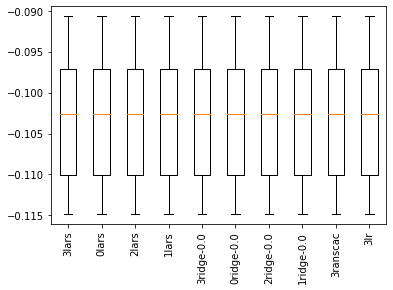

/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5971405.407604715, tolerance: 2680.909140684368
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12936385.372690056, tolerance: 2661.645072862257
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12936385.372690056, tolerance: 2661.645072862257
  positive)
/Users/juan/miniconda3/envs/analysis/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: 

In [4]:
# initial time
tic = datetime.now()
# load dataset
X, y = load_dataset()
# get model list
models = get_models()
# add gbm models
#models = get_gbm_models(models, use_xgb=False)
# define transform pipelines
pipelines = [pipeline_none, pipeline_standardize, pipeline_normalize, pipeline_std_norm]
# evaluate models
results = evaluate_models(X, y, models, pipelines, repeats=3)
# summarize results
summarize_results(results, top_n=10)
# final time
toc = datetime.now()
# time spent
tictoc = ((toc-tic).seconds)/60. # minutes
print ("\nProcess start: %s"%tic)
print ("Process finish: %s"%toc)
print ("Process time spent %s minutes"%tictoc)